In [60]:
import html
import pandas as pd

In [61]:
import geopandas as gpd

In [62]:
import os

In [63]:
from math import ceil

In [64]:
os.chdir('C:\\Users\\rgarcia\\Documents\\Data')

In [65]:
# retira lista de nomes de candidatos a presidente

cands = pd.read_json('https://resultados.tse.jus.br/oficial/ele2022/545/dados/br/br-c0001-e000545-011-f.json').loc['agr', 'carg']
cand_nums = pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(cands, max_level=0)['par'])[0])['cand'])[0])
cand_nums = cand_nums[['n', 'nmu']].dropna()
cand_nums['nmu'] = cand_nums.nmu.apply(lambda x: html.unescape(x).title())
cand_dict = dict(zip(cand_nums.n.to_list(), cand_nums.nmu.to_list()))
cand_dict['22'] = 'Jair Bolsonaro'

In [66]:
cand_dict

{'13': 'Lula', '22': 'Jair Bolsonaro'}

In [67]:
# gera lista de códigos de municipios para injetar no JSON

cod_mun = pd.read_csv('https://raw.githubusercontent.com/rafagarc/eleicoes_2022/main/mapas_1o_turno/codigos_IBGE_TSE.csv')
cod_mun['codigo_tse'] = cod_mun.codigo_tse.astype(str).str.zfill(5)
muns = cod_mun.codigo_tse.to_list()
cod_mun['uf'] = cod_mun.uf.str.lower()
list_mun = cod_mun['uf'].astype(str) + cod_mun['codigo_tse'].astype(str).to_list()

In [68]:
# gera chassi para concatenar a tabela
# munvotes = pd.DataFrame(columns=['muncod', '13', '14', '21', '27', '44', '12', '16', '15', '22', '30', '80'])


In [69]:
munvotes = pd.DataFrame(columns=['muncod', '13','22'])
for i in list_mun:
    raw_data = pd.read_json(f'https://resultados.tse.jus.br/oficial/ele2022/545/dados/{i[0:2]}/{i}-c0001-e000545-v.json')
    raw_mun = pd.json_normalize(raw_data['abr']).query('tpabr == "MU"')['cand']
    mun = pd.json_normalize(pd.json_normalize(raw_mun).T[0])
    mun = mun[['n', 'vap']].T
    mun.columns = mun.loc['n']
    mun = mun.drop('n')
    mun.insert(loc=0, column='muncod', value=[i])
    munvotes = pd.concat([munvotes,mun])

In [70]:
munvotes

,muncod,13,22
vap,ac01120,0,0
vap,ac01570,0,0
vap,ac01058,0,0
vap,ac01007,0,0
vap,ac01015,0,0
...,...,...,...
vap,to96199,0,0
vap,to73458,0,0
vap,to73237,0,0
vap,to96652,0,0


In [10]:
munvotes.columns = [cand_dict[i] if i in cand_dict.keys() else i for i in munvotes.columns]

In [11]:
# munvotes.to_csv('munvotes.csv', index=False)

In [12]:
munvotes = munvotes.set_index('muncod')

In [13]:
munvotes = munvotes.astype('int32')

In [14]:
# munvotes.sum()

In [15]:
munvotes['TOTAL'] = munvotes.sum(axis=1)

In [16]:
munvotes_pct = (munvotes.drop(columns='TOTAL').div(munvotes.TOTAL, axis=0)*100).round(2)

In [17]:
munvotes_pct['Bolsonaro - Lula (%)'] = (munvotes_pct['Jair Bolsonaro']-munvotes_pct['Lula']).round(2)

In [18]:
munvotes_pct['Votos válidos'] = munvotes.TOTAL

In [19]:
tse_codes = munvotes_pct.index.to_series().apply(lambda x: int(x[-5:]))

In [20]:
munvotes_pct.insert(loc=0, column='codigo_tse', value=tse_codes)

In [21]:
munvotes_pct

,codigo_tse,Lula,Padre Kelmon,Sofia Manzano,Constituinte Eymael,Soraya Thronicke,Ciro Gomes,Vera,Simone Tebet,Jair Bolsonaro,Felipe D'Avila,Léo Péricles,Bolsonaro - Lula (%),Votos válidos
muncod,,,,,,,,,,,,,,
ac01120,1120,21.30,0.08,0.00,0.00,0.52,1.64,0.01,2.70,73.59,0.15,0.00,52.29,7118
ac01570,1570,41.12,0.04,0.02,0.00,0.23,0.90,0.10,2.24,55.31,0.04,0.00,14.19,4871
ac01058,1058,29.50,0.03,0.03,0.02,0.37,1.76,0.01,3.51,64.67,0.08,0.01,35.17,14138
ac01007,1007,29.33,0.12,0.03,0.00,0.80,2.71,0.01,4.90,62.03,0.07,0.00,32.70,7263
ac01015,1015,27.12,0.00,0.02,0.00,0.77,2.00,0.00,4.39,65.61,0.10,0.00,38.49,6011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
to96199,96199,71.39,0.00,0.00,0.00,0.43,0.83,0.00,1.48,25.89,0.00,0.00,-45.50,3998
to73458,73458,60.18,0.00,0.00,0.00,0.41,1.71,0.00,2.39,35.31,0.00,0.00,-24.87,1464
to73237,73237,64.84,0.00,0.14,0.00,0.36,2.17,0.00,3.25,29.24,0.00,0.00,-35.60,1385


In [22]:
tse_ibge = pd.read_csv('https://raw.githubusercontent.com/rafagarc/eleicoes_2022/main/mapas_1o_turno/codigos_IBGE_TSE.csv')

In [23]:
munvotes_agg = tse_ibge.merge(munvotes_pct, how='left', on='codigo_tse')

In [24]:
munvotes_agg['codigo_ibge'] = munvotes_agg.codigo_ibge.astype(str)

In [25]:
munmap = gpd.read_file('BR_Municipios_2021_low_res.json')

In [26]:
munmap = munmap.rename(columns={'CD_MUN':'codigo_ibge'})

In [27]:
votemap = munmap.merge(munvotes_agg, on='codigo_ibge', how='left')

In [33]:
legbound = ceil(max((votemap['Bolsonaro - Lula (%)'].min()*-1, votemap['Bolsonaro - Lula (%)'].max())))

<AxesSubplot:>

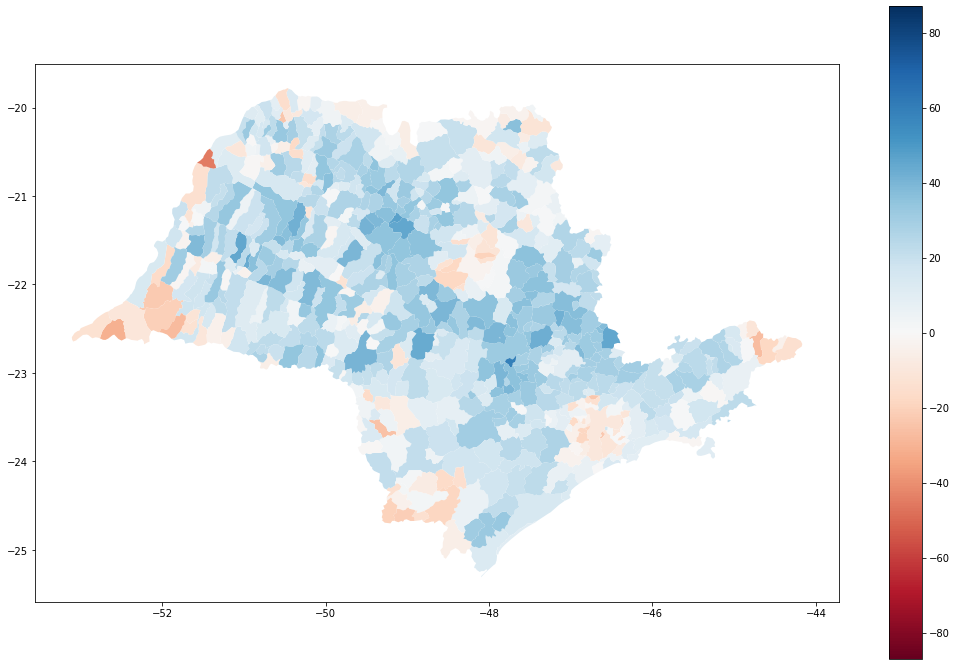

In [35]:
votemap[votemap.codigo_ibge.str.startswith('35')].plot(figsize=(18,12), column='Bolsonaro - Lula (%)', cmap='RdBu', legend=True, vmin=-legbound, vmax=legbound)